In [1]:
from osier import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import normalize
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from pymoo.termination.ftol import MultiObjectiveSpaceTermination
from pymoo.visualization.scatter import Scatter
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.termination.robust import RobustTermination
from pymoo.core.parameters import set_params, hierarchical

from pygenesys.utils.tsprocess import aggregate
from unyt import kW, MW, GW, hour

from copy import deepcopy
import time
import dill

In [2]:
n_hours = 24
n_days = 365
N = n_hours*n_days
scale = 1
total_demand = 187e3 * n_days/365 * GW

In [3]:
wdf = pd.read_csv('../../../2021-dotson-ms/data/railsplitter_data.csv', 
                  usecols=['time', 'kw'], 
                  index_col='time', 
                  parse_dates=True)
# wdf = wdf[wdf.index.year == 2017][:N]/scale
sdf = pd.read_csv('../../../2021-dotson-ms/data/solarfarm_data.csv', 
                  usecols=['time', 'kw'],
                  index_col='time', 
                  parse_dates=True)
# sdf = sdf[sdf.index.year == 2017][:N]/scale
ddf = pd.read_csv('../../../2021-dotson-ms/data/uiuc_demand_data.csv',
                  usecols=['time', 'kw'],
                  index_col='time',
                  parse_dates=True)
# ddf = ddf[ddf.index.year == 2017][:N]/scale

In [4]:
ddf = aggregate(ddf,
                N_seasons=365,
                N_hours=n_hours,
                kind='demand',
                groupby='day')
sdf = aggregate(sdf,
                N_seasons=365,
                N_hours=n_hours,
                kind='cf',
                groupby='day')
wdf = aggregate(wdf,
                N_seasons=365,
                N_hours=n_hours,
                kind='cf',
                groupby='day')

In [5]:
ddf = ddf.flatten()[:N]
ddf = ddf/ddf.sum() * total_demand
sdf = sdf.flatten()[:N]
wdf = wdf.flatten()[:N]

In [6]:
to_MDOLLARS = 1e-6

In [7]:
nuclear = ThermalTechnology(technology_name='Nuclear',
                     capacity=18.609404*GW,
                     capital_cost=50*(1/kW)*to_MDOLLARS,
                     om_cost_variable=0.0*to_MDOLLARS,
                     om_cost_fixed=177.73741*(1/kW)*to_MDOLLARS,
                     fuel_cost=5.811*(1/(MW*hour))*to_MDOLLARS,
                     ramp_up_rate=0.0,
                     ramp_down_rate=0.0,
                     )
nuclear_adv = ThermalTechnology(technology_name='Nuclear_Adv',
                     capacity=0*GW,
                     capital_cost=4916.4*(1/kW)*to_MDOLLARS,
                     om_cost_variable=0.0*to_MDOLLARS,
                     om_cost_fixed=118.99*(1/kW)*to_MDOLLARS,
                     fuel_cost=9.158*(1/(MW*hour))*to_MDOLLARS,
                     ramp_up_rate=0.25,
                     ramp_down_rate=0.25,
                     )
natural_gas = ThermalTechnology(technology_name='NaturalGas_Conv',
                         capacity=8.3751331*GW,
                         capital_cost=959.58*(1/kW)*to_MDOLLARS,
                         om_cost_variable=0.0*to_MDOLLARS,
                         om_cost_fixed=11.1934*(1/kW)*to_MDOLLARS,
                         fuel_cost=22.387*(1/(MW*hour))*to_MDOLLARS,
                         ramp_up_rate=1.0,
                         ramp_down_rate=1.0,
                         )
biomass = ThermalTechnology(technology_name='Biomass',
                         capacity=0*scale,
                         capital_cost=3436*(1/kW)*to_MDOLLARS,
                         om_cost_variable=0.0*to_MDOLLARS,
                         om_cost_fixed=123*(1/kW)*to_MDOLLARS,
                         fuel_cost=47*(1/(MW*hour))*to_MDOLLARS,
                         ramp_up_rate=1.0,
                         ramp_down_rate=1.0,
                         )
natural_gas_adv = ThermalTechnology(technology_name='NaturalGas_Adv',
                         capacity=0*GW,
                         capital_cost=1891.0*(1/kW)*to_MDOLLARS,
                         om_cost_variable=0.0*to_MDOLLARS,
                         om_cost_fixed=26.99*(1/kW)*to_MDOLLARS,
                         fuel_cost=27.475*(1/(MW*hour))*to_MDOLLARS,
                         ramp_up_rate=1.0,
                         ramp_down_rate=1.0,
                         )
coal = ThermalTechnology(technology_name='Coal_Conv',
                         capacity=0*GW,
                         capital_cost=1000*(1/kW)*to_MDOLLARS,
                         om_cost_variable=0.0*to_MDOLLARS,
                         om_cost_fixed=40.7033*(1/kW)*to_MDOLLARS,
                         fuel_cost=21.369*(1/(MW*hour))*to_MDOLLARS,
                         ramp_up_rate=0.5,
                         ramp_down_rate=0.5,
                         )
coal_adv = ThermalTechnology(technology_name='Coal_Adv',
                         capacity=0*GW,
                         capital_cost=4924.6*(1/kW)*to_MDOLLARS,
                         om_cost_variable=0.0*to_MDOLLARS,
                         om_cost_fixed=58.24*(1/kW)*to_MDOLLARS,
                         fuel_cost=36.6329*(1/(MW*hour))*to_MDOLLARS,
                         ramp_up_rate=0.5,
                         ramp_down_rate=0.5,
                         )
battery = StorageTechnology(technology_name='Battery',
                         capacity=0.81534126*GW,
                         capital_cost=613*(1/kW)*to_MDOLLARS,
                         om_cost_variable=0*to_MDOLLARS,
                         om_cost_fixed=15.32*(1/kW)*to_MDOLLARS,
                         fuel_cost=0*to_MDOLLARS,
                         storage_duration=4,
                         efficiency=0.85,
                         initial_storage=0,
                         )
wind = Technology(technology_name='WindTurbine',
                  renewable=True,
                  dispatchable=False,
                  fuel_type='wind',
                  capacity=0*GW, 
                  capital_cost=1180.6*(1/kW)*to_MDOLLARS,
                  om_cost_fixed=33.11*(1/kW)*to_MDOLLARS)
solar = Technology(technology_name='SolarPanel',
                  renewable=True,
                  dispatchable=False,
                  fuel_type='solar',
                  capacity=2.8103015*GW, 
                  capital_cost=673.2*(1/kW)*to_MDOLLARS,
                  om_cost_fixed=8.05*(1/kW)*to_MDOLLARS)

In [8]:
nuclear.co2 = 1.2e-5 * scale
nuclear_adv.co2 = nuclear.co2
solar.co2 = 4.8e-5 * scale
wind.co2 = 1.1e-5 * scale
natural_gas.co2 = 4.90e-4 * scale
natural_gas_adv.co2 = 4.9e-5 * scale
coal.co2 = 8.20e-4 * scale
coal_adv.co2 = 2.20e-4 * scale
biomass.co2 = 2.30e-4 * scale
battery.co2 = 2.32e-5 * scale

In [9]:
nuclear.cap_credit = 1.0
nuclear_adv.cap_credit = 1.0 
solar.cap_credit = 0.188
wind.cap_credit = 0.35
natural_gas.cap_credit = 1.0
natural_gas_adv.cap_credit = 1.0
coal.cap_credit = 1.0
coal_adv.cap_credit = 1.0
biomass.cap_credit = 1.0
battery.cap_credit = 0.5

In [10]:
techs = [nuclear, 
         nuclear_adv,
         natural_gas,
         natural_gas_adv,
         coal,
         coal_adv,
         biomass,
         battery,
         solar,
         wind
         ]

In [11]:
techs

[Nuclear: 18609.404000000002 MW,
 Nuclear_Adv: 0.0 MW,
 NaturalGas_Conv: 8375.1331 MW,
 NaturalGas_Adv: 0.0 MW,
 Coal_Conv: 0.0 MW,
 Coal_Adv: 0.0 MW,
 Biomass: 0.0 MW,
 Battery: 815.3412599999999 MW,
 SolarPanel: 2810.3015 MW,
 WindTurbine: 0.0 MW]

In [12]:
annualized_capital_cost(techs)

454.3511832911201

In [13]:
from pymoo.core.repair import Repair

class PortfolioRepair(Repair):

    def _do(self, problem, X, **kwargs):
        # zero out small numbers
        # make sure the portfolio equals one
        X = X/X.sum(axis=1, keepdims=True)
        X[X<1e-2] = 0
        X = X/X.sum(axis=1, keepdims=True)
#         I = np.eye(problem.n_var, problem.n_var) * problem.capacity_credit
#         X = ((X.T)/(I@X.T).sum(axis=0, keepdims=True)).T      
        return X

In [14]:
with open('../../../2023-dotson-prelim/data/2022-11-14-optimal_hyperparams.pkl', 'rb') as file:
    hyperparams = dill.load(file)

In [15]:
with open('../../../2023-dotson-prelim/data/2022-12-11-optimal_design_X.pkl', 'rb') as file:
    X_set = dill.load(file)

In [16]:
test_X = X_set[-1]*ddf.max()

In [17]:
for i,t in enumerate(techs):
    t.capacity = test_X[i]
techs

[Nuclear: 12629.229746806877 MW,
 Nuclear_Adv: 15003.940558026143 MW,
 NaturalGas_Conv: 0.0 MW,
 NaturalGas_Adv: 0.0 MW,
 Coal_Conv: 0.0 MW,
 Coal_Adv: 0.0 MW,
 Biomass: 0.0 MW,
 Battery: 0.0 MW,
 SolarPanel: 0.0 MW,
 WindTurbine: 1618.183333787175 MW]

In [18]:
wind = (wdf/wdf.max()*X_set[-1,-1]*ddf.max())
sun = (sdf/sdf.max()*X_set[-1,-2]*ddf.max())
net_dem = (ddf-wind-sun)

In [19]:
model = DispatchModel(technology_list= [t
                                        for t in techs 
                                        if t.dispatchable], 
                      net_demand=net_dem, verbose=True)

In [20]:
from osier import reliability_tech


In [22]:
model.technology_list[-1].fuel_cost

unyt_quantity(10., '1/(GW*hr)')

In [23]:
model.solve()


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile '/tmp/tmph9tjyja9.cplex.log' open.
CPLEX> Problem '/tmp/tmpmay937ew.pyomo.lp' read.
Read time = 0.32 sec. (24.87 ticks)
CPLEX> Problem name         : /tmp/tmpmay937ew.pyomo.lp
Objective sense      : Minimize
Variables            :  105121  [Nneg: 1,  Fix: 8760,  Box: 96360]
Objective nonzeros   :   87600
Linear constraints   :  271547  [Less: 192713,  Greater: 70073,  Equal: 8761]
  Nonzeros           :  613168
  RHS nonzeros       :   70079

Variables            : Min LB: 0.000000         Max UB: 1.000000e+07   
Objective nonzeros   : Min   : 0.0001000000     Max   : 10.00000       
Linear con

In [24]:
model.objective

1407.0580450757302

In [25]:
model.results.sum(axis=0)

Nuclear            110632.052582
Nuclear_Adv         71606.451503
NaturalGas_Conv         0.000000
NaturalGas_Adv          0.000000
Coal_Conv               0.000000
Coal_Adv                0.000000
Biomass                 0.000000
Battery                 0.000000
Curtailment            -3.612525
LoadLoss               10.840330
Battery_charge          0.000000
Battery_level           0.000000
dtype: float64

In [22]:
model.technology_list[-1].om_cost_variable

unyt_quantity(10000., '1/(MW*hr)')

In [24]:
(10*(1/(kW*hr))*1e-6).to(1/(MW*hr))

unyt_quantity(0.01, '1/(MW*hr)')

In [14]:
algorithm = NSGA2(
    pop_size=10,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
#     sampling=np.eye(10),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PolynomialMutation(eta=50),
    eliminate_duplicates=True,
    repair = PortfolioRepair()
)
set_params(algorithm, hierarchical(hyperparams))
# termination = RobustTermination(
#     MultiObjectiveSpaceTermination(tol=1, n_skip=5), period=5)
termination = get_termination("n_gen", 5)

In [15]:
from osier.models.capacity_expansion import CapacityExpansion
problem = CapacityExpansion(technology_list=techs,
                            objectives=[total_cost, annual_co2],
                            demand=ddf,
                            solar=sdf,
                            wind=wdf)

In [15]:
res = minimize(problem,
               algorithm,
               termination,
               pf=False,
               seed=5,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      4 |             - |             -
     2 |       20 |      7 |  0.1431317734 |         ideal
     3 |       30 |      9 |  0.0418675892 |         ideal
     4 |       40 |     10 |  0.1004490582 |         ideal
     5 |       50 |     10 |  0.1620221018 |         ideal


In [16]:
F = res.F
X = res.X

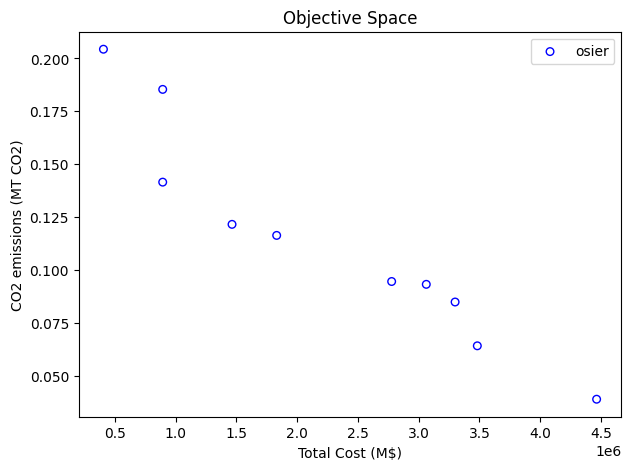

In [17]:
plt.figure(figsize=(7, 5), facecolor='w')
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue', label='osier')
plt.title("Objective Space")
plt.xlabel("Total Cost (M$)")
plt.ylabel("CO2 emissions (MT CO2)")
plt.legend()
plt.show()

# Test arbitrary objectives

1. Minimize nuclear capacity
2. Minimize blackout time

In [20]:
np.array([t.capacity 
         for t in techs
         if "Nuclear" in t.technology_name]).sum()

18.609404

In [16]:
def reliability(technology_list, dispatch_model):
    return dispatch_model.results['LoadLoss'].sum()
def nuclear_capacity(technology_list, dispatch_model):
    return np.array([t.capacity 
                     for t in technology_list
                     if "Nuclear" in t.technology_name]).sum()
def non_renewable_capacity(technology_list, dispatch_model=None):
    cap_total = np.array([t.capacity for t in technology_list]).sum()
    vre_total = np.array([t.capacity 
                          for t in technology_list 
                          if t.renewable]).sum()
    
    return cap_total - vre_total

In [30]:
non_renewable_capacity(techs)

27.79987836

In [22]:
problem = CapacityExpansion(technology_list=techs,
                            objectives=[reliability, nuclear_capacity],
                            demand=ddf,
                            solar=sdf,
                            wind=wdf)
res = minimize(problem,
               algorithm,
               termination,
               pf=False,
               seed=5,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      4 |             - |             -
     2 |       20 |      5 |  0.0238179951 |         ideal
     3 |       30 |      3 |  0.1493184039 |         ideal
     4 |       40 |      2 |  0.1463341619 |         ideal
     5 |       50 |      4 |  0.0961956617 |         ideal


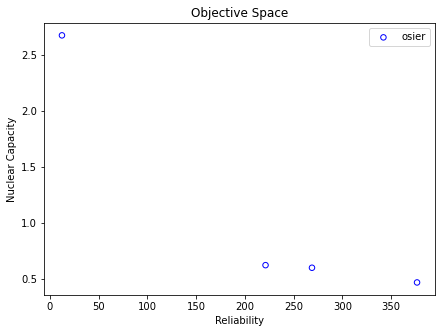

In [23]:
F = res.F
X = res.X

plt.figure(figsize=(7, 5), facecolor='w')
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue', label='osier')
plt.title("Objective Space")
plt.xlabel("Reliability")
plt.ylabel("Nuclear Capacity")
plt.legend()
plt.show()

In [31]:
problem = CapacityExpansion(technology_list=techs,
                            objectives=[reliability, non_renewable_capacity],
                            demand=ddf,
                            solar=sdf,
                            wind=wdf)
res = minimize(problem,
               algorithm,
               termination,
               pf=False,
               seed=5,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      5 |             - |             -
     2 |       20 |      8 |  0.0258692785 |         ideal
     3 |       30 |     10 |  0.1224352335 |         ideal
     4 |       40 |     10 |  0.0809967427 |         ideal
     5 |       50 |     10 |  0.0195006999 |         ideal


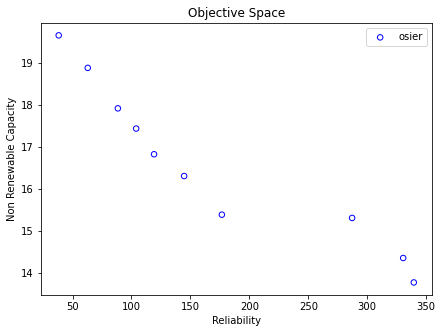

In [33]:
F = res.F
X = res.X

plt.figure(figsize=(7, 5), facecolor='w')
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue', label='osier')
plt.title("Objective Space")
plt.xlabel("Reliability")
plt.ylabel("Non Renewable Capacity")
plt.legend()
plt.show()

In [37]:
X.shape

(10, 10)

In [36]:
len(techs)

10

In [39]:
labels = get_tech_names(techs)

In [41]:
display(F,X)

array([[ 38.2605834 ,  19.65496098],
       [339.42513555,  13.77741547],
       [287.11264358,  15.31151789],
       [144.64940972,  16.30799173],
       [176.63804882,  15.3898062 ],
       [119.13491107,  16.8265792 ],
       [ 62.89249   ,  18.8817578 ],
       [103.95205388,  17.4377807 ],
       [ 88.44199849,  17.91820472],
       [330.41491301,  14.35881022]])

array([[0.12614347, 0.01603502, 0.0690318 , 0.15399041, 0.        ,
        0.06445249, 0.43380442, 0.        , 0.07717331, 0.05936908],
       [0.10404046, 0.21516211, 0.04378354, 0.        , 0.10815266,
        0.05094881, 0.        , 0.08316492, 0.31014229, 0.08460521],
       [0.01099407, 0.04055754, 0.07856605, 0.05251474, 0.17091843,
        0.07568917, 0.13733831, 0.10606849, 0.12543382, 0.20191938],
       [0.13466429, 0.1720834 , 0.        , 0.15833113, 0.17481933,
        0.        , 0.07652452, 0.        , 0.13929141, 0.14428592],
       [0.12364869, 0.15687211, 0.0194019 , 0.14537957, 0.16051903,
        0.        , 0.07026478, 0.        , 0.16897407, 0.15493986],
       [0.13143079, 0.01670713, 0.07192528, 0.        , 0.        ,
        0.06715402, 0.45198739, 0.        , 0.08040804, 0.18038735],
       [0.15752396, 0.02002402, 0.08620472, 0.28939376, 0.02004141,
        0.08048622, 0.1758161 , 0.        , 0.09637158, 0.07413823],
       [0.11071745, 0.14148247, 0.1614841

In [42]:
X[1]

array([0.10404046, 0.21516211, 0.04378354, 0.        , 0.10815266,
       0.05094881, 0.        , 0.08316492, 0.31014229, 0.08460521])

(0.0, 30.0)

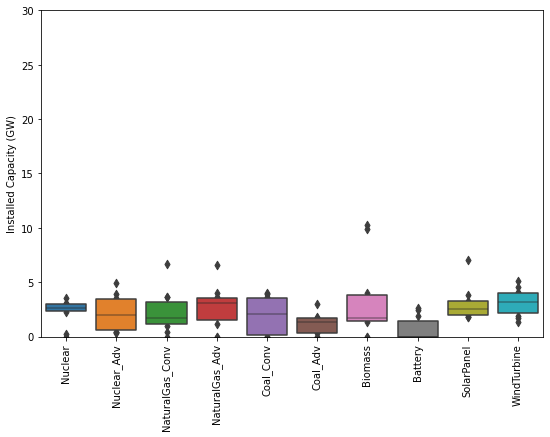

In [40]:
fig, ax = plt.subplots(figsize=(9,6), facecolor='w')
sb.boxenplot(ax=ax, data=(res.X)*problem.capacity_requirement)
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_ylabel('Installed Capacity (GW)')
ax.set_ylim(0, 30)

In [43]:
row = 1
net_dem = (ddf-(wdf/wdf.max()*X[row,-1]*problem.capacity_requirement)-(sdf/sdf.max()*X[row,-2]*problem.capacity_requirement))
for t, x in zip(techs, X[row]):
    t.capacity = x*problem.capacity_requirement
display(X[row])
display(techs)
model = DispatchModel(technology_list= [t
                                        for t in techs 
                                        if t.dispatchable], 
                      net_demand=net_dem, verbose=True)
model.solve()

array([0.10404046, 0.21516211, 0.04378354, 0.        , 0.10815266,
       0.05094881, 0.        , 0.08316492, 0.31014229, 0.08460521])

[Nuclear: 2.3682820817207633 MW,
 Nuclear_Adv: 4.897753838764082 MW,
 NaturalGas_Conv: 0.996648587448737 MW,
 NaturalGas_Adv: 0.0 MW,
 Coal_Conv: 2.4618883626894075 MW,
 Coal_Adv: 1.1597522726675287 MW,
 Biomass: 0.0 MW,
 Battery: 1.8930903239204593 MW,
 SolarPanel: 7.059795998965663 MW,
 WindTurbine: 1.9258758954813038 MW]


Welcome to IBM(R) ILOG(R) CPLEX(R) Interactive Optimizer 20.1.0.0
  with Simplex, Mixed Integer & Barrier Optimizers
5725-A06 5725-A29 5724-Y48 5724-Y49 5724-Y54 5724-Y55 5655-Y21
Copyright IBM Corp. 1988, 2020.  All Rights Reserved.

Type 'help' for a list of available commands.
Type 'help' followed by a command name for more
information on commands.

CPLEX> Logfile 'cplex.log' closed.
Logfile 'C:\Users\samgd\AppData\Local\Temp\tmppooo33gb.cplex.log' open.
CPLEX> Problem 'C:\Users\samgd\AppData\Local\Temp\tmp0jv811wi.pyomo.lp' read.
Read time = 0.00 sec. (0.11 ticks)
CPLEX> Problem name         : C:\Users\samgd\AppData\Local\Temp\tmp0jv811wi.pyomo.lp
Objective sense      : Minimize
Variables            :     577  [Nneg: 1,  Box: 576]
Objective nonzeros   :     480
Linear constraints   :    1475  [Less: 1049,  Greater: 377,  Equal: 49]
  Nonzeros           :    3328
  RHS nonzeros       :    1001

Variables            : Min LB: 0.000000         Max UB: 1.000000e+10   
Objective nonzer

In [47]:
cols = [t.technology_name for t in techs if t.dispatchable]
cols.append('Battery_charge')
cols.append('Curtailment')
cols.append('LoadLoss')

<AxesSubplot:>

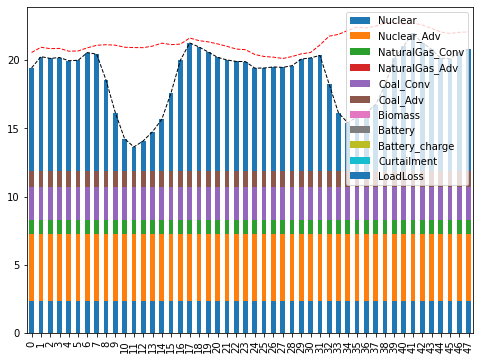

In [48]:
fig,ax = plt.subplots(facecolor='w', figsize=(8,6))
N = 48
d = 0
# model.results[['Nuclear', 'Battery', 'Battery_charge']].plot(ax=ax,kind='bar', stacked=True)
ax.plot(range(N), net_dem[d*N:(d+1)*N], color='k', lw=1, linestyle='--')
ax.plot(range(N), ddf[d*N:(d+1)*N], color='r', lw=1, linestyle='--')
model.results[cols][d*N:(d+1)*N].plot(ax=ax,kind='bar', stacked=True)

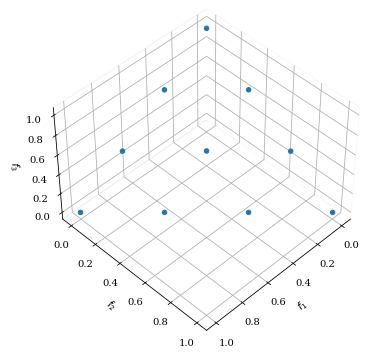

In [13]:
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter

ref_dirs = get_reference_directions("energy", 3, 10, seed=5)
Scatter().add(ref_dirs).show()

In [14]:
algorithm = UNSGA3(
    ref_dirs=ref_dirs,
    pop_size=10,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
#     sampling=np.eye(10),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PolynomialMutation(eta=50),
    eliminate_duplicates=True,
    repair = PortfolioRepair()
)
set_params(algorithm, hierarchical(hyperparams))
# termination = RobustTermination(
#     MultiObjectiveSpaceTermination(tol=1, n_skip=5), period=5)
termination = get_termination("n_gen", 5)

In [17]:
problem = CapacityExpansion(technology_list=techs,
                            objectives=[total_cost, annual_co2, reliability],
                            demand=ddf,
                            solar=sdf,
                            wind=wdf)
res = minimize(problem,
               algorithm,
               termination,
               pf=False,
               seed=5,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       10 |      3 |             - |             -
     2 |       20 |      2 |  0.5169058745 |         ideal
     3 |       30 |      3 |  0.2234957169 |         ideal
     4 |       40 |      4 |  0.0412951690 |         ideal
     5 |       50 |      4 |  0.0522468165 |         ideal


In [18]:
res.exec_time

633.301383972168

In [20]:
X = res.X
F = res.F

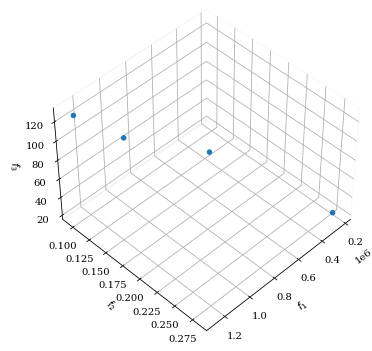

In [21]:
plot = Scatter()
plot.add(F)
plot.show()